In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import streamlit as st
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.0 MB/s eta 0:00:00


In [6]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
# Step 1: Web scrape Wikipedia page for Malaysia
url = "https://en.wikipedia.org/wiki/South_Korea"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

In [8]:
print(f"Response Status: {response.status_code}")
print(f"Page Title: {soup.title.string}")

Response Status: 200
Page Title: South Korea - Wikipedia


In [9]:
# Step 2: Scrape only text
paragraphs = []
content_div = soup.find("div", {"id": "mw-content-text"})
if content_div:
    for p in content_div.find_all("p"):
        if p.text.strip():
            paragraphs.append(p.text)

In [10]:
# Combine all paragraphs into one text
raw_text = ' '.join(paragraphs)

In [11]:
print(f"Total characters extracted: {len(raw_text)}")
print(f"Preview of the text: {raw_text[:500]}...")

Total characters extracted: 90583
Preview of the text: South Korea,[c] officially the Republic of Korea (ROK),[d] is a country in East Asia. It constitutes the southern half of the Korean Peninsula and borders North Korea along the Korean Demilitarized Zone, with the Yellow Sea to the west and the Sea of Japan to the east. Like North Korea, South Korea claims to be the sole legitimate government of the entire peninsula and adjacent islands. It has a population of 51.71 million, of which half live in the Seoul Metropolitan Area, the ninth most populo...


In [12]:
# Step 3: Clean Text and preprocessing
def clean_text(text):
    # Remove citations [1], [2], etc.
    text = re.sub(r'\[\d+\]', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^\w\s.]', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_text = clean_text(raw_text)

In [13]:
print(f"Total characters after cleaning: {len(cleaned_text)}")
print(f"Preview of the cleaned text: {cleaned_text[:500]}...")

Total characters after cleaning: 86952
Preview of the cleaned text: South Koreac officially the Republic of Korea ROKd is a country in East Asia. It constitutes the southern half of the Korean Peninsula and borders North Korea along the Korean Demilitarized Zone with the Yellow Sea to the west and the Sea of Japan to the east. Like North Korea South Korea claims to be the sole legitimate government of the entire peninsula and adjacent islands. It has a population of 51.71 million of which half live in the Seoul Metropolitan Area the ninth most populous metropoli...


In [14]:
# Step 4: Use Sentence Tokenizer and sentence tokenize
sentences = sent_tokenize(cleaned_text)
print(f"Total number of sentences: {len(sentences)}")
print(f"First 5 sentences:")
for i, sent in enumerate(sentences[:5]):
    print(f"{i+1}. {sent}")



Total number of sentences: 602
First 5 sentences:
1. South Koreac officially the Republic of Korea ROKd is a country in East Asia.
2. It constitutes the southern half of the Korean Peninsula and borders North Korea along the Korean Demilitarized Zone with the Yellow Sea to the west and the Sea of Japan to the east.
3. Like North Korea South Korea claims to be the sole legitimate government of the entire peninsula and adjacent islands.
4. It has a population of 51.71 million of which half live in the Seoul Metropolitan Area the ninth most populous metropolitan area in the world other major cities include Busan Daegu and Incheon.
5. The Korean Peninsula was inhabited as early as the Lower Paleolithic period.


In [15]:
# Step 5: Use TextBlob and analyze_sentiment() function to calculate sentiment of sentences
def get_sentiment(sentence):
    analysis = TextBlob(sentence)
    polarity = analysis.sentiment.polarity

    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

In [16]:
# Calculate sentiment for each sentence
sentiment_results = []
for sentence in sentences:
    blob = TextBlob(sentence)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    sentiment = get_sentiment(sentence)

    sentiment_results.append({
        'sentence': sentence,
        'polarity': polarity,
        'subjectivity': subjectivity,
        'sentiment': sentiment
    })

In [17]:
# Step 6: Create a dataframe of sentences and sentiment
sentiment_df = pd.DataFrame(sentiment_results)

In [18]:
print(f"Dataframe shape: {sentiment_df.shape}")

Dataframe shape: (602, 4)


In [19]:
print("\nFirst 5 rows of the sentiment dataframe:")


First 5 rows of the sentiment dataframe:


In [20]:
print(sentiment_df.head())

                                            sentence  polarity  subjectivity  \
0  South Koreac officially the Republic of Korea ...  0.000000      0.000000   
1  It constitutes the southern half of the Korean... -0.055556      0.055556   
2  Like North Korea South Korea claims to be the ...  0.000000      0.437500   
3  It has a population of 51.71 million of which ...  0.081439      0.408333   
4  The Korean Peninsula was inhabited as early as...  0.100000      0.300000   

  sentiment  
0   neutral  
1   neutral  
2   neutral  
3   neutral  
4   neutral  


In [21]:
print("\nSentiment distribution:")
print(sentiment_df['sentiment'].value_counts())


Sentiment distribution:
sentiment
neutral     365
positive    203
negative     34
Name: count, dtype: int64


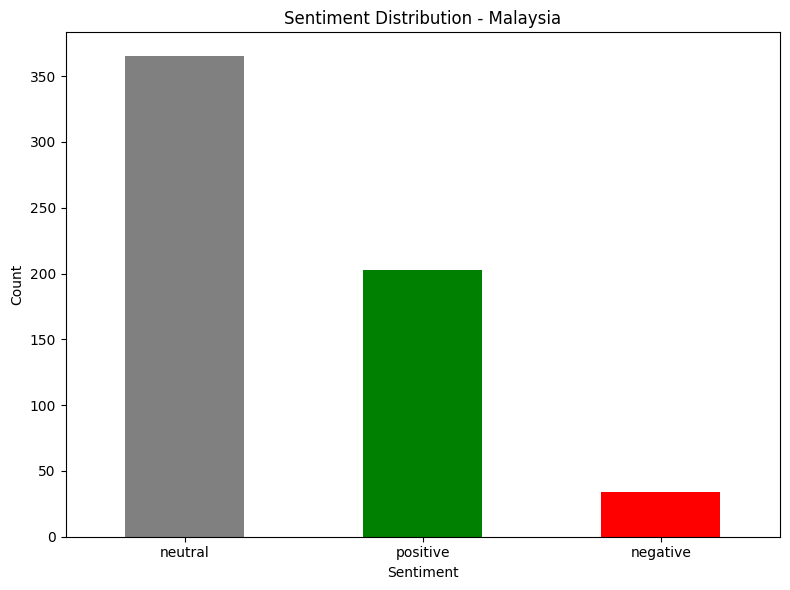

In [22]:
# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_df['sentiment'].value_counts().plot(kind='bar', color=['gray', 'green', 'red'])
plt.title('Sentiment Distribution - Malaysia')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
# Step 7: Word tokenize the text data
words = word_tokenize(cleaned_text.lower())
print(f"Total words found: {len(words)}")
print(f"First 20 words: {words[:20]}")

Total words found: 14450
First 20 words: ['south', 'koreac', 'officially', 'the', 'republic', 'of', 'korea', 'rokd', 'is', 'a', 'country', 'in', 'east', 'asia', '.', 'it', 'constitutes', 'the', 'southern', 'half']


In [24]:
# Step 8: Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.isalpha() and word not in stop_words]

In [25]:
print(f"Words after removing stopwords: {len(filtered_words)}")
print(f"First 20 filtered words: {filtered_words[:20]}")

Words after removing stopwords: 8167
First 20 filtered words: ['south', 'koreac', 'officially', 'republic', 'korea', 'rokd', 'country', 'east', 'asia', 'constitutes', 'southern', 'half', 'korean', 'peninsula', 'borders', 'north', 'korea', 'along', 'korean', 'demilitarized']


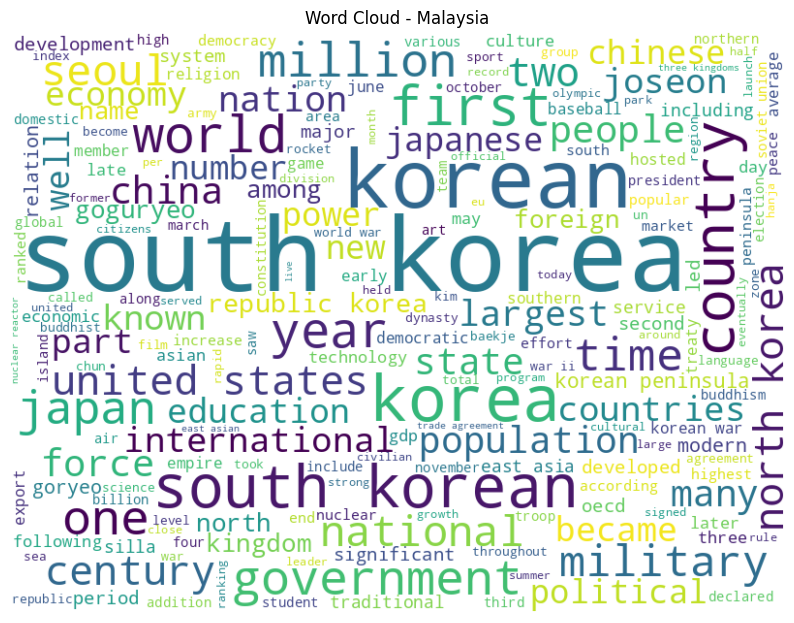

In [26]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=600, background_color='white').generate(' '.join(filtered_words))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Malaysia')
plt.show()

In [27]:
# Most common words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)
words_df = pd.DataFrame(common_words, columns=['word', 'count'])

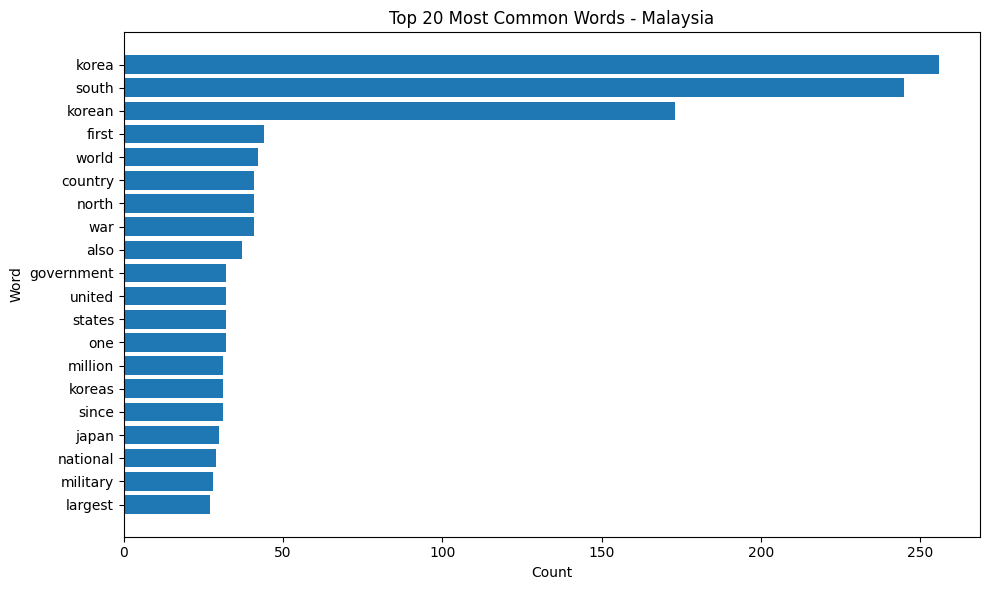

In [28]:
plt.figure(figsize=(10, 6))
plt.barh(words_df['word'], words_df['count'])
plt.title('Top 20 Most Common Words - Malaysia')
plt.xlabel('Count')
plt.ylabel('Word')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [29]:
# Step 11: Apply TFIDF Vectorizer on sentences and sentiment dataframe
# Step 12: Use only positive and negative sentiments only & ignore neutral
filtered_sentiment_df = sentiment_df[sentiment_df['sentiment'] != 'neutral']
print(f"Dataframe shape after removing neutral sentiments: {filtered_sentiment_df.shape}")
print(filtered_sentiment_df['sentiment'].value_counts())

# Prepare data for ML models
X = filtered_sentiment_df['sentence']
y = filtered_sentiment_df['sentiment']

# Convert text to TFIDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2)
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"TFIDF matrix shape: {X_tfidf.shape}")

Dataframe shape after removing neutral sentiments: (237, 4)
sentiment
positive    203
negative     34
Name: count, dtype: int64
TFIDF matrix shape: (237, 623)


In [30]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 189
Testing samples: 48


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         7
    positive       0.85      1.00      0.92        41

    accuracy                           0.85        48
   macro avg       0.43      0.50      0.46        48
weighted avg       0.73      0.85      0.79        48



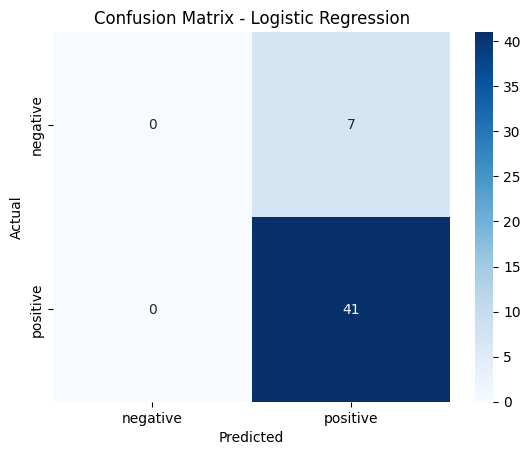

In [32]:
import seaborn as sns

# Logistic Regression
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)

# Predictions
lr_preds = lr_model.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_preds))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, lr_preds)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         7
    positive       0.85      1.00      0.92        41

    accuracy                           0.85        48
   macro avg       0.43      0.50      0.46        48
weighted avg       0.73      0.85      0.79        48



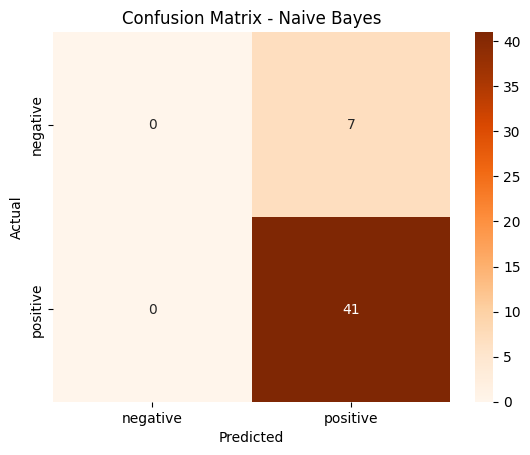

In [33]:
# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
nb_preds = nb_model.predict(X_test)

# Evaluation
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_preds))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, nb_preds)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [34]:
print("Accuracy Score:", accuracy_score(y_test, nb_preds))

Accuracy Score: 0.8541666666666666
